# Notebook II

**Training**

In this notebook, we will train a multitude of image classification models that aim to diagnose whether a patient has developed pneumonia based upon his or her chest X-ray image.

**Models**

Tentatively, the following mainstream models targeting image classification tasks will be used.

- AlexNet
- ResNet-50
- Inception v3


Note that these models are pre-trained on [ImageNet](http://image-net.org/). To serve our goal, we will modify the model architecture and fine-tune the pre-trained weights rather than train new ones from scratch.

**Dimension of Input Image**

Three resizing schemes will be used.

1. $224\times224\times3$. Since most ImageNet-based CNN's are trained on input images of size 224 by 224, we will downsize our images to the same dimension.
2. $299\times299\times3$. This is the expected input dimension to the InceptionNet v3.
3. $600\times600\times3$. After examining the overall distribution of the image dimensions, we opt for a dimension of 600 by 600. Since this alternative is larger than the previous setting and presumably preserves more information of the original input images, we expect to see a more desirable performance in return.


**Data Augmentation**

In order for models to better generalize to unseen data, we will carry out various data augmentation techniques on the training data and compare the performance to models trained purely on the original training, undistorted data.

## Preparation Code

### Mount to Google Drive

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd '/content/gdrive/My Drive/Projects/Pneumonia_X_Ray/'

/content/gdrive/My Drive/Projects/Pneumonia_X_Ray


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Add path to sys
import sys
sys.path.insert(0, 'code')
sys.path.insert(0, 'code/imbalanced-dataset-sampler')

In [0]:
from models import *
from utils import *

### Set device

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is: {}'.format(device))

Device is: cuda


### Set paths

In [0]:
# Paths
trainPath = 'data/chest_xray_cropped/train'
testPath = 'data/chest_xray_cropped/test'
valPath = 'data/chest_xray_cropped/val'

### Create a dataloader from training data

Here we use the default transform object.

**Training set**

In [0]:
batchSize = 32

dataloaderTrain, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, balance=True, train=True)

Mode: Training is True


KeyboardInterrupt: ignored

**Validation set**

In [0]:
batchSize = 32

dataloaderVal, classToIdxVal = imagesToDataloader(valPath, batch_size=batchSize, train=False)

Mode: Training is False
Dataloader created


In [0]:
# Test if dataloader is created correctly

trainDataIter = iter(dataloaderTrain)
sampleImg, sampleLabel = next(trainDataIter)
print(sampleImg)
print(sampleLabel)

tensor([[[[-0.5137, -0.4980, -0.5059,  ...,  0.7176,  0.5843,  0.5529],
          [-0.6000, -0.6392, -0.6471,  ...,  0.6941,  0.6627,  0.6784],
          [-0.8039, -0.8353, -0.7961,  ...,  0.6706,  0.7020,  0.7255],
          ...,
          [ 0.4980,  0.5294,  0.5529,  ...,  0.3804,  0.3412,  0.3098],
          [ 0.5216,  0.5373,  0.5529,  ...,  0.3412,  0.3255,  0.3176],
          [ 0.5294,  0.5294,  0.5137,  ...,  0.3647,  0.3490,  0.3333]],

         [[-0.5137, -0.4980, -0.5059,  ...,  0.7176,  0.5843,  0.5529],
          [-0.6000, -0.6392, -0.6471,  ...,  0.6941,  0.6627,  0.6784],
          [-0.8039, -0.8353, -0.7961,  ...,  0.6706,  0.7020,  0.7255],
          ...,
          [ 0.4980,  0.5294,  0.5529,  ...,  0.3804,  0.3412,  0.3098],
          [ 0.5216,  0.5373,  0.5529,  ...,  0.3412,  0.3255,  0.3176],
          [ 0.5294,  0.5294,  0.5137,  ...,  0.3647,  0.3490,  0.3333]],

         [[-0.5137, -0.4980, -0.5059,  ...,  0.7176,  0.5843,  0.5529],
          [-0.6000, -0.6392, -

**Display a couple of input images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


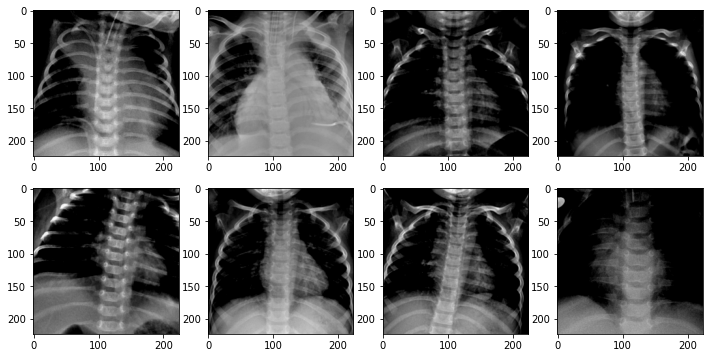

In [0]:
sampleImgTransposed = sampleImg.transpose(1, 2).transpose(2, 3)[:8, :, :, :]

# Plot a few distorted training images

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, imgTensor in enumerate(sampleImgTransposed):
  curAx = axes[i // 4][i % 4]
  curAx.imshow(imgTensor.numpy(), cmap='gray')
plt.show()

## Training

At this step, we will use the training images to train our classifiers. Additionally, a small validation set will be used to evaluate the varied configurations as well as to showcase the trajectory of the model performance as the number of epochs increases.

### AlexNet Model

#### Scheme 1: Standard

In [0]:
# Instantiate a model
alexModel = AlexNetXray()
alexModel.to(device)

AlexNetXray(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use SGD with a momentum of 0.9
optimizer = optim.SGD(alexModel.parameters(), lr=lr, momentum=0.9)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Path to save model
modelPath = '/content/gdrive/My Drive/Projects/Pneumonia_X_Ray/models'

# Print frequency
freq = 10

In [0]:
len(dataloaderTrain)

162

In [0]:
# Train!

numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  alexModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = alexModel(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain), lossTrain / countTrain))



  # Validate
  alexModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = alexModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the scheduler
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'alexnet_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(alexModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0157
Step 20/162: Avg training loss 0.0194
Step 30/162: Avg training loss 0.0170
Step 40/162: Avg training loss 0.0157
Step 50/162: Avg training loss 0.0141
Step 60/162: Avg training loss 0.0136
Step 70/162: Avg training loss 0.0133
Step 80/162: Avg training loss 0.0126
Step 90/162: Avg training loss 0.0117
Step 100/162: Avg training loss 0.0111
Step 110/162: Avg training loss 0.0106
Step 120/162: Avg training loss 0.0101
Step 130/162: Avg training loss 0.0097
Step 140/162: Avg training loss 0.0093
Step 150/162: Avg training loss 0.0090
Step 160/162: Avg training loss 0.0087
Step 162/162: Avg training loss 0.0086
Validating...
Val avg loss 0.0029
Val accuracy 0.9740
Val precision 0.9524
Val recall 1.0000
Val f-score 0.9756
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0044
Step 20/162: Avg training loss 0.0044
Step

#### Scheme 2: Conduct data augmentation on the training set

The following tranformations are applied to the input images at random.

- Color Jitter
- Random Rotation
- Random Horizontal Flip

We will create a separate training data loader that applies the distortions above.

In [0]:
augs = [transforms.ColorJitter(0.3, 0.3, 0.3, 0.3), transforms.RandomRotation(45), transforms.RandomHorizontalFlip()]

transformsAug = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomChoice(augs),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

In [0]:
batchSize = 32

dataloaderTrainAug, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=transformsAug, balance=True, train=True)

Mode: Training is True
Dataloader created


In [0]:
# Get one batch of training data

trainDataIter = iter(dataloaderTrainAug)
sampleImg, sampleLabel = next(trainDataIter)

In [0]:
sampleImgTransposed = sampleImg.transpose(1, 2).transpose(2, 3)[:8, :, :, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


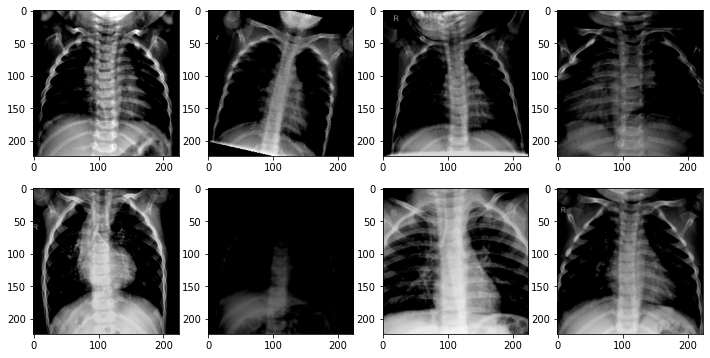

In [0]:
# Plot a few distorted training images

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, imgTensor in enumerate(sampleImgTransposed):
  curAx = axes[i // 4][i % 4]
  curAx.imshow(imgTensor.numpy(), cmap='gray')
plt.show()

In [0]:
# Instantiate model
alexModelAug = AlexNetXray()
alexModelAug.to(device)

# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use SGD with a momentum of 0.9
optimizer = optim.SGD(alexModelAug.parameters(), lr=lr, momentum=0.9)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)

  alexModelAug.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrainAug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = alexModelAug(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrainAug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrainAug), lossTrain / countTrain))

  # Validate
  alexModelAug.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = alexModelAug(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the scheduler
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'alexnet_aug_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(alexModelAug.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))


==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0176
Step 20/162: Avg training loss 0.0151
Step 30/162: Avg training loss 0.0137
Step 40/162: Avg training loss 0.0125
Step 50/162: Avg training loss 0.0113
Step 60/162: Avg training loss 0.0105
Step 70/162: Avg training loss 0.0096
Step 80/162: Avg training loss 0.0091
Step 90/162: Avg training loss 0.0090
Step 100/162: Avg training loss 0.0087
Step 110/162: Avg training loss 0.0085
Step 120/162: Avg training loss 0.0081
Step 130/162: Avg training loss 0.0079
Step 140/162: Avg training loss 0.0077
Step 150/162: Avg training loss 0.0074
Step 160/162: Avg training loss 0.0073
Step 162/162: Avg training loss 0.0073
Validating...
Val avg loss 0.0040
Val accuracy 0.9610
Val precision 0.9302
Val recall 1.0000
Val f-score 0.9639
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0029
Step 20/162: Avg training loss 0.0035
Step

#### Scheme 3: Input image dimension 600 by 600

**Prepare for data**

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

trans600 = transforms.Compose([
                            transforms.Resize(600),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])


In [0]:
# Dataloaders

batchSize = 32

dataloaderTrain600, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600, balance=True, train=True)
dataloaderVal600, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=trans600, train=False)

Mode: Training is True
Dataloader created
Mode: Training is False
Dataloader created


**Plot a batch to verify whether the images are properly transformed**

In [0]:
# Get one batch of training data

trainDataIter = iter(dataloaderTrain600)
sampleImg, sampleLabel = next(trainDataIter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


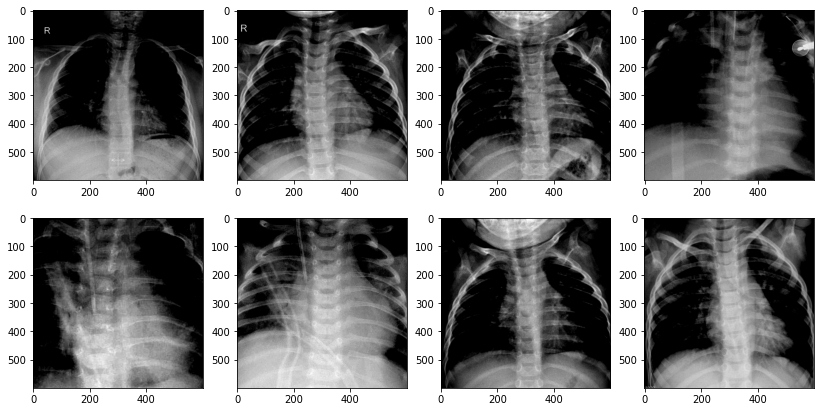

In [0]:
sampleImgTransposed = sampleImg.transpose(1, 2).transpose(2, 3)[:8, :, :, :]

# Plot a few distorted training images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, imgTensor in enumerate(sampleImgTransposed):
  curAx = axes[i // 4][i % 4]
  curAx.imshow(imgTensor.numpy(), cmap='gray')
plt.show()

**Train the model**

In [0]:
# Instantiate a model
alexModel = AlexNetXray()
alexModel.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNetXray(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use SGD with a momentum of 0.9
optimizer = optim.SGD(alexModel.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  alexModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = alexModel(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600), lossTrain / countTrain))

  # Validate
  alexModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = alexModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the optimizer 
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'alexnet_600_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(alexModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0198
Step 20/162: Avg training loss 0.0154
Step 30/162: Avg training loss 0.0126
Step 40/162: Avg training loss 0.0114
Step 50/162: Avg training loss 0.0103
Step 60/162: Avg training loss 0.0098
Step 70/162: Avg training loss 0.0094
Step 80/162: Avg training loss 0.0088
Step 90/162: Avg training loss 0.0087
Step 100/162: Avg training loss 0.0082
Step 110/162: Avg training loss 0.0078
Step 120/162: Avg training loss 0.0077
Step 130/162: Avg training loss 0.0075
Step 140/162: Avg training loss 0.0072
Step 150/162: Avg training loss 0.0070
Step 160/162: Avg training loss 0.0068
Step 162/162: Avg training loss 0.0068
Validating...
Val avg loss 0.0040
Val accuracy 0.9740
Val precision 1.0000
Val recall 0.9500
Val f-score 0.9744
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0029
Step 20/162: Avg training loss 0.0024
Step

#### Scheme 4: Input image dimension 600 by 600 + Data Augmentation

This scheme combines Scheme 2 and Scheme 3. That is, the training data have a dimension of 600 * 600 and are applied with random transformations.

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

augs = [transforms.ColorJitter(0.3, 0.3, 0.3, 0.3), transforms.RandomRotation(45), transforms.RandomHorizontalFlip()]

transforms600Aug = transforms.Compose([
                            transforms.Resize(600),
                            transforms.RandomChoice(augs),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

In [0]:
# Dataloaders

batchSize = 32

dataloaderTrain600Aug, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=transforms600Aug, balance=True, train=True)
dataloaderVal600Aug, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=transforms600, train=False)

Mode: Training is True
Dataloader created
Mode: Training is False
Dataloader created


In [0]:
# Get one batch of training data

trainDataIter = iter(dataloaderTrain600Aug)
sampleImg, sampleLabel = next(trainDataIter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


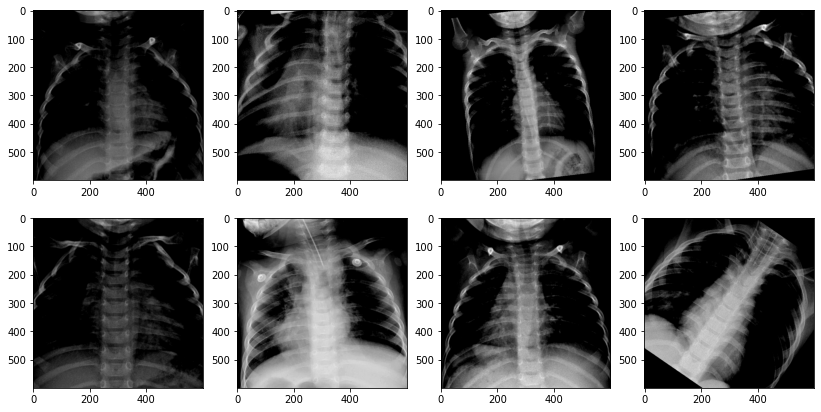

In [0]:
sampleImgTransposed = sampleImg.transpose(1, 2).transpose(2, 3)[:8, :, :, :]

# Plot a few distorted training images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, imgTensor in enumerate(sampleImgTransposed):
  curAx = axes[i // 4][i % 4]
  curAx.imshow(imgTensor.numpy(), cmap='gray')
plt.show()

In [0]:
# Instantiate a model
alexModel = AlexNetXray()
alexModel.to(device)

# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use SGD with a momentum of 0.9
optimizer = optim.SGD(alexModel.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
# Train!

minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  alexModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600Aug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = alexModel(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600Aug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600Aug), lossTrain / countTrain))

  # Validate
  alexModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600Aug):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = alexModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the optimizer 
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'alexnet_600_aug_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(alexModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0196
Step 20/162: Avg training loss 0.0198
Step 30/162: Avg training loss 0.0183
Step 40/162: Avg training loss 0.0168
Step 50/162: Avg training loss 0.0163
Step 60/162: Avg training loss 0.0162
Step 70/162: Avg training loss 0.0157
Step 80/162: Avg training loss 0.0148
Step 90/162: Avg training loss 0.0144
Step 100/162: Avg training loss 0.0140
Step 110/162: Avg training loss 0.0135
Step 120/162: Avg training loss 0.0130
Step 130/162: Avg training loss 0.0128
Step 140/162: Avg training loss 0.0125
Step 150/162: Avg training loss 0.0120
Step 160/162: Avg training loss 0.0116
Step 162/162: Avg training loss 0.0116
Validating...
Val avg loss 0.0069
Val accuracy 0.8961
Val precision 0.9000
Val recall 0.9000
Val f-score 0.9000
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0053
Step 20/162: Avg training loss 0.0051
Step

---

### ResNet Model

In this section, we will train a ResNet-50 on the training data.

#### Scheme 1: Standard

In [0]:
# Instantiate a ResNet model
resnetModel = ResNet50Xray()
resnetModel.to(device)

ResNet50Xray(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
# Hyperparameters
lr = 0.002
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(resnetModel.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  resnetModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = resnetModel(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain), lossTrain / countTrain))



  # Validate
  resnetModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = resnetModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the scheduler
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'resnet_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(resnetModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0187
Step 20/162: Avg training loss 0.0146
Step 30/162: Avg training loss 0.0131
Step 40/162: Avg training loss 0.0117
Step 50/162: Avg training loss 0.0108
Step 60/162: Avg training loss 0.0099
Step 70/162: Avg training loss 0.0092
Step 80/162: Avg training loss 0.0087
Step 90/162: Avg training loss 0.0085
Step 100/162: Avg training loss 0.0084
Step 110/162: Avg training loss 0.0081
Step 120/162: Avg training loss 0.0079
Step 130/162: Avg training loss 0.0078
Step 140/162: Avg training loss 0.0077
Step 150/162: Avg training loss 0.0075
Step 160/162: Avg training loss 0.0073
Step 162/162: Avg training loss 0.0073
Validating...
Val avg loss 0.0077
Val accuracy 0.8961
Val precision 0.9211
Val recall 0.8750
Val f-score 0.8974
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0057
Step 20/162: Avg training loss 0.0053
Step

#### Scheme 2: Conduct data augmentation on the training set

In [0]:
# Instantiate model
resnetModelAug = ResNet50Xray()
resnetModelAug.to(device)

# Hyperparameters
lr = 0.002
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(resnetModelAug.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)

  resnetModelAug.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrainAug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = resnetModelAug(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrainAug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrainAug), lossTrain / countTrain))

  # Validate
  resnetModelAug.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = resnetModelAug(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Step the scheduler
      scheduler.step(lossVal)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'resnet_aug_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(resnetModelAug.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))


==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0286
Step 20/162: Avg training loss 0.0249
Step 30/162: Avg training loss 0.0224
Step 40/162: Avg training loss 0.0206
Step 50/162: Avg training loss 0.0185
Step 60/162: Avg training loss 0.0171
Step 70/162: Avg training loss 0.0161
Step 80/162: Avg training loss 0.0150
Step 90/162: Avg training loss 0.0146
Step 100/162: Avg training loss 0.0143
Step 110/162: Avg training loss 0.0137
Step 120/162: Avg training loss 0.0133
Step 130/162: Avg training loss 0.0130
Step 140/162: Avg training loss 0.0127
Step 150/162: Avg training loss 0.0125
Step 160/162: Avg training loss 0.0124
Step 162/162: Avg training loss 0.0128
Validating...
Val avg loss 0.0128
Val accuracy 0.8182
Val precision 0.7500
Val recall 0.9750
Val f-score 0.8478
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0105
Step 20/162: Avg training loss 0.0106
Step

#### Scheme 3: Input image dimension 600 by 600

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

trans600 = transforms.Compose([
                            transforms.Resize(600),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

In [0]:
# Dataloaders

batchSize = 16

dataloaderTrain600, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600, balance=True, train=True)
dataloaderVal600, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=trans600, train=False)

Mode: Training is True
Dataloader created
Mode: Training is False
Dataloader created


In [0]:
# Instantiate a ResNet model
resnetModel600 = ResNet50Xray()
resnetModel600.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet50Xray(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=resnetModel600.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 20

In [0]:
# Train!

numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  resnetModel600.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = resnetModel600(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600), lossTrain / countTrain))

  # Validate
  resnetModel600.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = resnetModel600(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'resnet_600_best.pt'), 'wb') as f:
      torch.save(resnetModel600.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 20/323: Avg training loss 0.3917
Step 40/323: Avg training loss 0.2120
Step 60/323: Avg training loss 0.1517
Step 80/323: Avg training loss 0.1220
Step 100/323: Avg training loss 0.1038
Step 120/323: Avg training loss 0.0911
Step 140/323: Avg training loss 0.0815
Step 160/323: Avg training loss 0.0743
Step 180/323: Avg training loss 0.0688
Step 200/323: Avg training loss 0.0650
Step 220/323: Avg training loss 0.0615
Step 240/323: Avg training loss 0.0579
Step 260/323: Avg training loss 0.0555
Step 280/323: Avg training loss 0.0530
Step 300/323: Avg training loss 0.0508
Step 320/323: Avg training loss 0.0489
Step 323/323: Avg training loss 0.0487
Validating...
Val avg loss 0.0331
Val accuracy 0.8701
Val precision 0.8750
Val recall 0.8750
Val f-score 0.8750
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 20/323: Avg training loss 0.0222
Step 40/323: Avg training loss 0.0219

KeyboardInterrupt: ignored

#### Scheme 4: Input image dimension 600 by 600 + Data Augmentation

This scheme combines Scheme 2 and Scheme 3. That is, the training data have a dimension of 600 * 600 and are applied with random transformations.

In [0]:
# Path to save model
modelPath = '/content/gdrive/My Drive/Projects/Pneumonia_X_Ray/models'

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

augs = [transforms.ColorJitter(0.3, 0.3, 0.3, 0.3), transforms.RandomRotation(45), transforms.RandomHorizontalFlip()]

trans600Aug = transforms.Compose([
                            transforms.Resize(600),
                            transforms.RandomChoice(augs),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

In [0]:
# Dataloaders

batchSize = 8

dataloaderTrain600Aug, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600Aug, balance=True, train=True)
dataloaderVal600, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=trans600, train=False)

Mode: Training is True
Dataloader created
Mode: Training is False
Dataloader created


In [0]:
# Instantiate a ResNet model
resnetModel600Aug = ResNet50Xray()
resnetModel600Aug.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet50Xray(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=resnetModel600Aug.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 30

In [0]:
# Train!

numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  resnetModel600Aug.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600Aug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    out = resnetModel600Aug(inputs)
    # Compute loss
    loss = criterion(out, labels)
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600Aug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600Aug), lossTrain / countTrain))

  # Validate
  resnetModel600Aug.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = resnetModel600Aug(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'resnet_600_aug_best.pt'), 'wb') as f:
      torch.save(resnetModel600Aug.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 30/645: Avg training loss 0.1730
Step 60/645: Avg training loss 0.1345
Step 90/645: Avg training loss 0.1187
Step 120/645: Avg training loss 0.1103
Step 150/645: Avg training loss 0.1035
Step 180/645: Avg training loss 0.0972
Step 210/645: Avg training loss 0.0933
Step 240/645: Avg training loss 0.0916
Step 270/645: Avg training loss 0.0911
Step 300/645: Avg training loss 0.0902
Step 330/645: Avg training loss 0.0885
Step 360/645: Avg training loss 0.0868
Step 390/645: Avg training loss 0.0845
Step 420/645: Avg training loss 0.0854
Step 450/645: Avg training loss 0.0854
Step 480/645: Avg training loss 0.0851
Step 510/645: Avg training loss 0.0847
Step 540/645: Avg training loss 0.0844
Step 570/645: Avg training loss 0.0830
Step 600/645: Avg training loss 0.0831
Step 630/645: Avg training loss 0.0823
Step 645/645: Avg training loss 0.0825
Validating...
Val avg loss 0.2123
Val accuracy 0.5325
Val precision 1.0000
Val reca

## InceptionNet Model

#### Scheme 1: Standard

In [0]:
# Define a transforms object that resizes the input image to 299 by 299

trans299 = transforms.Compose([
                            transforms.Resize(299),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

# Create dataloaders from training and validation data

batchSize = 32

# Training data
dataloaderTrain299, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans299, balance=True, train=True)
# Validation data
dataloaderVal299, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=trans299, train=False)


Mode: Training is False
Dataloader created


In [0]:
# Path to save model
modelPath = '/content/gdrive/My Drive/Projects/Pneumonia_X_Ray/models'

In [0]:
# Instantate an InceptionNet model

inceptionModel = InceptionNetXray()
inceptionModel.to(device)

InceptionNetXray(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
 

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=inceptionModel.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

weightLossAux = 0.4
numEpochs = 10
minValLoss = np.inf

for epoch in range(1, numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  inceptionModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain299):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outPrimary, outAux = inceptionModel(inputs)
    # Compute loss
    lossPrimary = criterion(outPrimary, labels)
    lossAux = criterion(outAux, labels)
    loss = lossPrimary + lossAux * weightLossAux
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain299):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain299), lossTrain / countTrain))

  # Validate
  inceptionModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal299):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = inceptionModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'inceptionnet_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(inceptionModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0376
Step 20/162: Avg training loss 0.0352
Step 30/162: Avg training loss 0.0314
Step 40/162: Avg training loss 0.0287
Step 50/162: Avg training loss 0.0276
Step 60/162: Avg training loss 0.0252
Step 70/162: Avg training loss 0.0231
Step 80/162: Avg training loss 0.0215
Step 90/162: Avg training loss 0.0211
Step 100/162: Avg training loss 0.0203
Step 110/162: Avg training loss 0.0196
Step 120/162: Avg training loss 0.0196
Step 130/162: Avg training loss 0.0192
Step 140/162: Avg training loss 0.0188
Step 150/162: Avg training loss 0.0184
Step 160/162: Avg training loss 0.0179
Step 162/162: Avg training loss 0.0178
Validating...
Val avg loss 0.0128
Val accuracy 0.8961
Val precision 0.8333
Val recall 1.0000
Val f-score 0.9091
Model after Epoch 2 was saved
==================== EPOCH 3 ====================
Training...
Step 10/162: Avg training loss 0.0099
Step 20/162: Avg training loss 0.0104
Step

#### Scheme 2: Conduct data augmentation on the training set

In [0]:
# Define a transforms object

augs = [transforms.ColorJitter(0.3, 0.3, 0.3, 0.3), transforms.RandomRotation(45), transforms.RandomHorizontalFlip()]

transforms299Aug = transforms.Compose([
                            transforms.Resize(299),
                            transforms.RandomChoice(augs),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

In [0]:
# Create dataloaders

batchSize = 32

dataloaderTrain299Aug, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=transforms299Aug, balance=True, train=True)

Mode: Training is True
Dataloader created


In [0]:
# Instantiate a model

inceptionModel = InceptionNetXray()
inceptionModel.to(device)

InceptionNetXray(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
 

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=inceptionModel.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 10

In [0]:
# Train!

weightLossAux = 0.4
numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  inceptionModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain299Aug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outPrimary, outAux = inceptionModel(inputs)
    # Compute loss
    lossPrimary = criterion(outPrimary, labels)
    lossAux = criterion(outAux, labels)
    loss = lossPrimary + lossAux * weightLossAux
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain299Aug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain299Aug), lossTrain / countTrain))

  # Validate
  inceptionModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal299):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = inceptionModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'inceptionnet_aug_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(inceptionModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 10/162: Avg training loss 0.0644
Step 20/162: Avg training loss 0.0477
Step 30/162: Avg training loss 0.0416
Step 40/162: Avg training loss 0.0399
Step 50/162: Avg training loss 0.0376
Step 60/162: Avg training loss 0.0358
Step 70/162: Avg training loss 0.0348
Step 80/162: Avg training loss 0.0333
Step 90/162: Avg training loss 0.0322
Step 100/162: Avg training loss 0.0312
Step 110/162: Avg training loss 0.0309
Step 120/162: Avg training loss 0.0307
Step 130/162: Avg training loss 0.0311
Step 140/162: Avg training loss 0.0306
Step 150/162: Avg training loss 0.0302
Step 160/162: Avg training loss 0.0298
Step 162/162: Avg training loss 0.0313
Validating...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val avg loss 0.0354
Val accuracy 0.4805
Val precision 0.0000
Val recall 0.0000
Val f-score 0.0000
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 10/162: Avg training loss 0.0266
Step 20/162: Avg training loss 0.0254
Step 30/162: Avg training loss 0.0238
Step 40/162: Avg training loss 0.0238
Step 50/162: Avg training loss 0.0228
Step 60/162: Avg training loss 0.0221
Step 70/162: Avg training loss 0.0215
Step 80/162: Avg training loss 0.0210
Step 90/162: Avg training loss 0.0207
Step 100/162: Avg training loss 0.0202
Step 110/162: Avg training loss 0.0198
Step 120/162: Avg training loss 0.0195
Step 130/162: Avg training loss 0.0194
Step 140/162: Avg training loss 0.0222
Step 150/162: Avg training loss 0.0230
Step 160/162: Avg training loss 0.0239
Step 162/162: Avg training loss 0.0255
Validating...
Val avg loss 0.5549
Val accuracy 0.5195
Val precision 0.5195
Val recall 1.0000
Val f-score 0.6838
==================== EPOCH 3 ===============

#### Scheme 3: Input image dimension 600 by 600

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

trans600 = transforms.Compose([
                            transforms.Resize(600),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

# Create dataloaders

batchSize = 16

dataloaderTrain600, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600, balance=True, train=True)
dataloaderVal600, classToIdx = imagesToDataloader(valPath, batch_size=batchSize, trans=trans600, train=False)


Mode: Training is True
Dataloader created
Mode: Training is False
Dataloader created


In [0]:
# Instantiate a model

inceptionModel = InceptionNetXray()
inceptionModel.to(device)

InceptionNetXray(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
 

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=inceptionModel.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 20

In [0]:
# Train!

weightLossAux = 0.4
numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  inceptionModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outPrimary, outAux = inceptionModel(inputs)
    # Compute loss
    lossPrimary = criterion(outPrimary, labels)
    lossAux = criterion(outAux, labels)
    loss = lossPrimary + lossAux * weightLossAux
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600), lossTrain / countTrain))

  # Validate
  inceptionModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = inceptionModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'inceptionnet_600_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(inceptionModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 20/323: Avg training loss 0.1083
Step 40/323: Avg training loss 0.0919
Step 60/323: Avg training loss 0.0826
Step 80/323: Avg training loss 0.0775
Step 100/323: Avg training loss 0.0726
Step 120/323: Avg training loss 0.0698
Step 140/323: Avg training loss 0.0661
Step 160/323: Avg training loss 0.0632
Step 180/323: Avg training loss 0.0610
Step 200/323: Avg training loss 0.0595
Step 220/323: Avg training loss 0.0580
Step 240/323: Avg training loss 0.0568
Step 260/323: Avg training loss 0.0555
Step 280/323: Avg training loss 0.0542
Step 300/323: Avg training loss 0.0530
Step 320/323: Avg training loss 0.0519
Step 323/323: Avg training loss 0.0517
Validating...
Val avg loss 0.0276
Val accuracy 0.8442
Val precision 0.8684
Val recall 0.8250
Val f-score 0.8462
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 20/323: Avg training loss 0.0346
Step 40/323: Avg training loss 0.0371

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val avg loss 98.5204
Val accuracy 0.4805
Val precision 0.0000
Val recall 0.0000
Val f-score 0.0000
==================== EPOCH 6 ====================
Training...
Step 20/323: Avg training loss 0.0480
Step 40/323: Avg training loss 0.0476
Step 60/323: Avg training loss 0.0418
Step 80/323: Avg training loss 0.0399
Step 100/323: Avg training loss 0.0370
Step 120/323: Avg training loss 0.0360
Step 140/323: Avg training loss 0.0344
Step 160/323: Avg training loss 0.0331
Step 180/323: Avg training loss 0.0320
Step 200/323: Avg training loss 0.0309
Step 220/323: Avg training loss 0.0307
Step 240/323: Avg training loss 0.0302
Step 260/323: Avg training loss 0.0298
Step 280/323: Avg training loss 0.0296
Step 300/323: Avg training loss 0.0290
Step 320/323: Avg training loss 0.0287
Step 323/323: Avg training loss 0.0300
Validating...
Val avg loss 0.0198
Val accuracy 0.8701
Val precision 0.9167
Val recall 0.8250
Val f-score 0.8684
Model after Epoch 6 was saved
==================== EPOCH 7 =========

#### Scheme 4: Input image dimension 600 by 600 + Data Augmentation

This scheme combines Scheme 2 and Scheme 3. That is, the training data have a dimension of 600 * 600 and are applied with random transformations.

In [0]:
# Define a transforms object that resizes the input image to 600 by 600

augs = [transforms.ColorJitter(0.3, 0.3, 0.3, 0.3), transforms.RandomRotation(45), transforms.RandomHorizontalFlip()]

trans600Aug = transforms.Compose([
                            transforms.Resize(600),
                            transforms.RandomChoice(augs),
                            transforms.Grayscale(num_output_channels=3),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])

# Create dataloader for training set
dataloaderTrain600Aug, classToIdx = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600Aug, balance=True, train=True)


Mode: Training is True
Dataloader created


In [0]:
# Instantiate a model

inceptionModel = InceptionNetXray()
inceptionModel.to(device)

InceptionNetXray(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
 

In [0]:
# Hyperparameters
lr = 0.01
numEpochs = 10

# Optimizer - we'll use Adam
optimizer = optim.Adam(params=inceptionModel.parameters(), lr=lr)

# Criterion - we'll use Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Print frequency
freq = 20

In [0]:
# Train!

weightLossAux = 0.4
numEpochs = 10
minValLoss = np.inf

for epoch in range(numEpochs):
  print('='*20, 'EPOCH {}'.format(epoch + 1), '='*20)
  inceptionModel.train()
  lossTrain, countTrain = 0, 0
  print('Training...')
  for i, (inputs, labels) in enumerate(dataloaderTrain600Aug):
    # Load a batch from dataloader
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outPrimary, outAux = inceptionModel(inputs)
    # Compute loss
    lossPrimary = criterion(outPrimary, labels)
    lossAux = criterion(outAux, labels)
    loss = lossPrimary + lossAux * weightLossAux
    # Zero grad
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Update training loss
    lossTrain += loss.item()
    countTrain += len(labels)

    # Print avg training loss every freq
    if (i + 1) % freq == 0 or (i + 1) == len(dataloaderTrain600Aug):
      print('Step {}/{}: Avg training loss {:.4f}'.format(i + 1, len(dataloaderTrain600Aug), lossTrain / countTrain))

  # Validate
  inceptionModel.eval()
  lossVal, countVal = 0, 0
  predList, trueList = [], []
  print('Validating...')
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaderVal600):
      # Load a batch from dataloader
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      out = inceptionModel(inputs)
      # Compute loss
      loss = criterion(out, labels)
      # Update val loss
      lossVal += loss.item()
      countVal += len(labels)
      # Save prediction
      out = F.softmax(out, dim=1)
      pred = out.max(1)[1]
      predList.extend(pred.detach().tolist())
      # Save ground truth
      trueList.extend(labels.detach().tolist())
  acc = accuracy_score(trueList, predList)
  precision, recall, fscore, _ = precision_recall_fscore_support(trueList, predList, average='binary', pos_label=1)

  print('Val avg loss {:.4f}'.format(lossVal / countVal))
  print('Val accuracy {:.4f}'.format(acc))
  print('Val precision {:.4f}'.format(precision))
  print('Val recall {:.4f}'.format(recall))
  print('Val f-score {:.4f}'.format(fscore))

  # Save the model
  if lossVal / countVal < minValLoss:
    minValLoss = lossVal / countVal
    with open(os.path.join(modelPath, 'inceptionnet_600_aug_best.pt'.format(epoch + 1)), 'wb') as f:
      torch.save(inceptionModel.state_dict(), f)
      print('Model after Epoch {} was saved'.format(epoch + 1))

==================== EPOCH 1 ====================
Training...
Step 20/323: Avg training loss 0.0888
Step 40/323: Avg training loss 0.0808
Step 60/323: Avg training loss 0.0759
Step 80/323: Avg training loss 0.0729
Step 100/323: Avg training loss 0.0709
Step 120/323: Avg training loss 0.0696
Step 140/323: Avg training loss 0.0686
Step 160/323: Avg training loss 0.0679
Step 180/323: Avg training loss 0.0673
Step 200/323: Avg training loss 0.0669
Step 220/323: Avg training loss 0.0664
Step 240/323: Avg training loss 0.0664
Step 260/323: Avg training loss 0.0660
Step 280/323: Avg training loss 0.0657
Step 300/323: Avg training loss 0.0654
Step 320/323: Avg training loss 0.0652
Step 323/323: Avg training loss 0.0653
Validating...
Val avg loss 0.0449
Val accuracy 0.5195
Val precision 0.5195
Val recall 1.0000
Val f-score 0.6838
Model after Epoch 1 was saved
==================== EPOCH 2 ====================
Training...
Step 20/323: Avg training loss 0.0632
Step 40/323: Avg training loss 0.0621

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val avg loss 0.1935
Val accuracy 0.4805
Val precision 0.0000
Val recall 0.0000
Val f-score 0.0000
==================== EPOCH 3 ====================
Training...
Step 20/323: Avg training loss 0.0621
Step 40/323: Avg training loss 0.0579
Step 60/323: Avg training loss 0.0589
Step 80/323: Avg training loss 0.0576
Step 100/323: Avg training loss 0.0558
Step 120/323: Avg training loss 0.0546
Step 140/323: Avg training loss 0.0534
Step 160/323: Avg training loss 0.0531
Step 180/323: Avg training loss 0.0521
Step 200/323: Avg training loss 0.0512
Step 220/323: Avg training loss 0.0505
Step 240/323: Avg training loss 0.0501
Step 260/323: Avg training loss 0.0495
Step 280/323: Avg training loss 0.0489
Step 300/323: Avg training loss 0.0481
Step 320/323: Avg training loss 0.0472
Step 323/323: Avg training loss 0.0472
Validating...
Val avg loss 0.0324
Val accuracy 0.8442
Val precision 0.8684
Val recall 0.8250
Val f-score 0.8462
Model after Epoch 3 was saved
==================== EPOCH 4 ==========

**End of notebook**